In [1]:
import onnxruntime as ort
import numpy as np
import cv2
import matplotlib.pyplot as plt
from utils import read_image, resize_and_pad, transform, cxcywh2xyxy, mulit_colors, load_yaml

In [2]:
ort.get_available_providers()

['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']

# yolo export

```sh
yolo task=detect mode=export imgsz=640 model=weights/rtdetr-l.pt format=onnx simplify=True device=0

# half=True only compatible with GPU export, i.e. use device=0
yolo task=detect mode=export imgsz=640 model=weights/rtdetr-l.pt format=onnx simplify=True device=0 half=True
```

# basic

In [3]:
# h w
imgsz = 640, 640

In [4]:
colors: list = mulit_colors(80)
colors[:5]

[(255, 76, 76), (255, 89, 76), (255, 103, 76), (255, 116, 76), (255, 130, 76)]

In [5]:
config: dict = load_yaml("./weights/yolov8.yaml")
config["names"]

{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou

# prepare image

(1080, 810, 3)


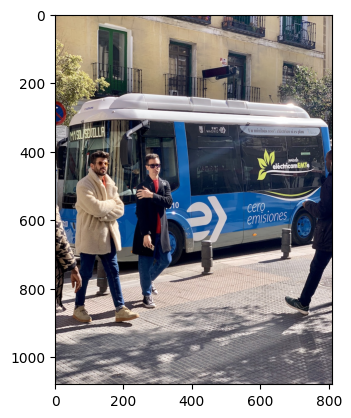

In [6]:
image_rgb = read_image("images/bus.jpg")
print(image_rgb.shape)
plt.imshow(image_rgb)

In [7]:
origin_shape = image_rgb.shape
origin_shape

(1080, 810, 3)

(640, 640, 3) 0.5925925925925926
255 0


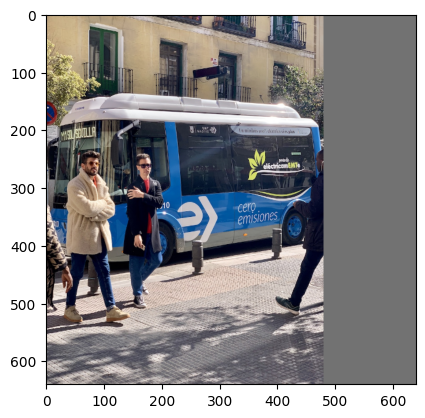

In [8]:
image_reized, ratio = resize_and_pad(image_rgb, imgsz)
print(image_reized.shape, ratio)
print(image_reized.max(), image_reized.min())
plt.imshow(image_reized)

In [9]:
input_array = transform(image_reized)
print(input_array.shape, input_array.max(), input_array.min())

(1, 3, 640, 640) 1.0 0.0


# load model

In [10]:
model_path = "./weights/rtdetr-l.onnx"
mode = "cuda"

In [11]:
so = ort.SessionOptions()
so.log_severity_level = 3
providers = {
    "cpu":  ["CPUExecutionProvider"],
    # https://onnxruntime.ai/docs/execution-providers/CUDA-ExecutionProvider.html
    "cuda": [
            ("CUDAExecutionProvider", {
                "device_id": 0,
                "arena_extend_strategy": "kNextPowerOfTwo",
                "gpu_mem_limit": 8 * 1024 * 1024 * 1024, # 8GB
                "cudnn_conv_algo_search": "EXHAUSTIVE",
                "do_copy_in_default_stream": True,
            }),
            "CPUExecutionProvider",
        ],
    # tensorrt
    # https://onnxruntime.ai/docs/execution-providers/TensorRT-ExecutionProvider.html
    # it is recommended you also register CUDAExecutionProvider to allow Onnx Runtime to assign nodes to CUDA execution provider that TensorRT does not support.
    # set providers to ["TensorrtExecutionProvider", "CUDAExecutionProvider"] with TensorrtExecutionProvider having the higher priority.
    "tensorrt": [
            ("TensorrtExecutionProvider", {
                "device_id": 0,
                "trt_max_workspace_size": 8 * 1024 * 1024 * 1024, # 8GB
                "trt_fp16_enable": False,
                # "trt_timing_cache_enable": True, # Enabling trt_timing_cache_enable will enable ORT TRT to use TensorRT timing cache to accelerate engine build time on a device with the same compute capability.
            }),
            ("CUDAExecutionProvider", {
                "device_id": 0,
                "arena_extend_strategy": "kNextPowerOfTwo",
                "gpu_mem_limit": 8 * 1024 * 1024 * 1024, # 8GB
                "cudnn_conv_algo_search": "EXHAUSTIVE",
                "do_copy_in_default_stream": True,
            }),
            "CPUExecutionProvider",
        ]
}[mode]

In [12]:
session = ort.InferenceSession(model_path, sess_options=so, providers=providers)

In [13]:
inputs  = session.get_inputs()
for i in inputs:
    print(i.name)

images


In [14]:
outputs = session.get_outputs()
for i in outputs:
    print(i.name)

output0


# run model

In [15]:
outputs: list[np.ndarray] = session.run(None, {inputs[0].name: input_array})
len(outputs)

1

# check result

In [16]:
results = outputs[0]
print(results.shape)

(1, 300, 84)


## 前4个值是loc [:4]

In [17]:
results[0, 0, :4]

array([0.3820402 , 0.44455606, 0.7247159 , 0.46299726], dtype=float32)

## 后面的值是cls [4:]

In [18]:
results[0, 0, 4:]

array([5.9505701e-03, 4.4761896e-03, 1.9113302e-02, 6.1879158e-03,
       8.4523559e-03, 9.4796795e-01, 1.1611879e-02, 9.0736151e-03,
       1.0004163e-02, 6.0528517e-03, 2.6075840e-03, 6.8063140e-03,
       6.2959790e-03, 1.0111511e-02, 5.9962273e-04, 1.2946129e-03,
       4.0191412e-04, 7.9843998e-03, 6.4823627e-03, 1.8618107e-03,
       1.3856292e-02, 9.8943710e-04, 1.5454173e-02, 3.3930540e-03,
       2.4077296e-03, 8.8429451e-03, 3.4199357e-03, 3.9288998e-03,
       4.2564273e-03, 7.2609782e-03, 1.2764871e-02, 4.3990612e-03,
       3.3325553e-03, 4.0028095e-03, 6.9536567e-03, 1.4352202e-02,
       9.0274811e-03, 4.1745901e-03, 4.3671727e-03, 2.7123690e-03,
       7.9531670e-03, 8.3525181e-03, 6.3352585e-03, 4.1707158e-03,
       2.2144318e-03, 4.3473244e-03, 2.9245615e-03, 5.3920746e-03,
       7.5812340e-03, 2.1274090e-03, 8.2328916e-03, 2.4505258e-03,
       7.8854561e-03, 1.3414025e-02, 2.9733777e-03, 3.9162636e-03,
       1.4270544e-03, 1.0328293e-02, 3.0136704e-03, 1.3989806e

In [19]:
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-x))

# postprocess

In [20]:
print(results.shape)
print(results.min(), results.max())

(1, 300, 84)
0.00016820431 0.9519539


In [21]:
bboxes, scores = np.split(results, (4, ), axis=-1)
bboxes.shape, scores.shape

((1, 300, 4), (1, 300, 80))

In [22]:
def threshold(results: np.ndarray, score_threshold: float = 0.25) -> np.ndarray:
    """类似nms操作,不过只需要通过得分限制

    Args:
        results (np.ndarray):           检测到的数据 [b, 8400, 84]
        score_threshold (float):        只有得分大于置信度的预测框会被保留下来,越大越严格

    Returns:
        (list[np.ndarray]): list代表每张图片,里面是一个ndarray,代表一张图片的结果,如果图片没有结果就为 []
            [
                np.ndarray([
                    [class_index, confidence, xmin, ymin, xmax, ymax],
                    ...
                ]),
            ]
    """

    detections = []
    # 循环每张图片的结果
    for result in results: # results: (b, 300, 84)
        bboxes, scores = np.split(result, (4, ), axis=-1)   # (300, 4) (300, 80)
        bboxes = cxcywh2xyxy(bboxes)                        # cxcywh2xyxy

        confidences: np.ndarray = scores.max(axis=-1)       # (300,)
        class_indexes: np.ndarray = scores.argmax(axis=-1)  # (300,)

        keep = confidences >= score_threshold               # (300,)

        bboxes_k = bboxes[keep]                             # (9, 4)
        confidences_k = confidences[keep]                   # (9,)
        class_indexes_k = class_indexes[keep]               # (9,)

        detection = np.concatenate(                        # (9, 6)
            (np.expand_dims(class_indexes_k, axis=-1),
            np.expand_dims(confidences_k, axis=-1),
            bboxes_k),
            axis=-1
        )
        detections.append(detection)

    return detections

In [23]:
thre_results = threshold(results)
print(thre_results[0].shape)
thre_results[0].min(), thre_results[0].max()

(9, 6)


(-0.0002384483814239502, 27.0)

In [24]:
origin_shape = image_rgb.shape
origin_shape

(1080, 810, 3)

# 坐标还原到原图尺寸

In [25]:
def to_origin_size(detection_in: np.ndarray, ratio: float, origin_shape: list[int]) -> np.ndarray:
    """将将检测结果的坐标还原到原图尺寸

    Args:
        detection_in (np.ndarray): [n, 6]
                [
                    [class_index, confidence, xmin, ymin, xmax, ymax],
                    ...
                ]
        ratio (float): 缩放比例
        origin_shape (list[int]): 原始形状 [h, w]

    Returns:
        np.ndarray: same as detection_in
    """
    if len(detection_in) == 0:
        return detection_in

    detection = detection_in.copy()
    # 还原到原图尺寸(detections_in是归一化的,因此要乘上imgsz,再除以缩放比例)
    detection[..., 2] = detection[..., 2] * imgsz[1] / ratio  # xmin
    detection[..., 3] = detection[..., 3] * imgsz[0] / ratio  # ymin
    detection[..., 4] = detection[..., 4] * imgsz[1] / ratio  # xmax
    detection[..., 5] = detection[..., 5] * imgsz[0] / ratio  # ymax

    # 防止框超出图片边界, 前面判断为True/False,后面选择更改的列,不选择更改的列会将整行都改为0
    detection[detection[..., 2] < 0.0, 2] = 0.0
    detection[detection[..., 3] < 0.0, 3] = 0.0
    detection[detection[..., 4] > origin_shape[1], 4] = origin_shape[1]
    detection[detection[..., 5] > origin_shape[0], 5] = origin_shape[0]

    return detection

In [26]:
detection = to_origin_size(thre_results[0], ratio, origin_shape)
print(detection.min(), detection.max())

0.0 904.6670866012573


# 画图

In [30]:
def figure(detection: np.ndarray, image: np.ndarray) -> np.ndarray:
    """将框画到原图

    Args:
        detections (np.ndarray): np.float32
                [
                    [class_index, confidence, xmin, ymin, xmax, ymax],
                    ...
                ]
        image (np.ndarray): 原图

    Returns:
        np.ndarray: 绘制的图
    """
    if len(detection) == 0:
        # 返回原图
        return image

    # Print results and save Figure with detections
    for i, detect in enumerate(detection):
        classId     = int(detect[0])
        confidence  = detect[1]
        xmin        = int(detect[2])
        ymin        = int(detect[3])
        xmax        = int(detect[4])
        ymax        = int(detect[5])

        # 绘制框
        image = cv2.rectangle(image, (xmin, ymin), (xmax, ymax), colors[classId], 2)

        # 文字
        label = str(config["names"][classId]) + " " + "{:.2f}".format(confidence)
        w, h = cv2.getTextSize(label, 0, fontScale=0.5, thickness=1)[0]  # text width, height

        # 添加文字背景
        image = cv2.rectangle(image, (xmin, ymin - 20 if ymin > 20 else ymin + h + 10), (xmin + w, ymin), colors[classId], cv2.FILLED)

        # 添加文字
        image = cv2.putText(
            img       = image,
            text      = label,
            org       = (xmin, ymin - 5 if ymin > 20 else ymin + h + 5),
            fontFace  = 0,
            fontScale = 0.5,
            color     = (0, 0, 0),
            thickness = 1,
            lineType  = cv2.LINE_AA,
        )

    return image

In [31]:
image_draw = figure(detection, cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR))

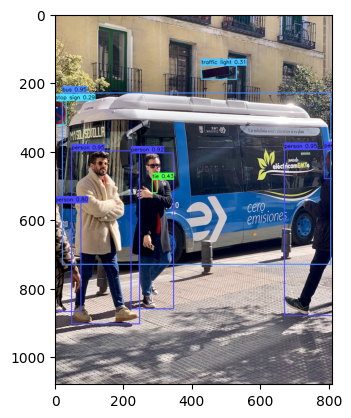

In [32]:
plt.imshow(cv2.cvtColor(image_draw, cv2.COLOR_BGR2RGB))